In [462]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import copy
from scipy import stats
from sklearn.metrics import f1_score
import pyspark
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [394]:
#import the csv data file
data = pd.read_csv("LiveStream-1-Cam-2-New-NL.csv")

In [395]:
data

,Date,Time,Timer,Temperature,Condition,Light,Car,CarDuration
0,2022-06-26,06-58-11.741,45.0,14.97,mist,Red,False,2
1,2022-06-26,06-58-18.254,8.0,14.97,mist,Green,False,0
2,2022-06-26,06-59-26.896,66.0,15.05,mist,Red,False,0
3,2022-06-26,06-59-35.205,7.0,15.05,mist,Green,False,1
4,2022-06-26,07-00-39.761,63.0,15.05,mist,Red,False,0
...,...,...,...,...,...,...,...,...
2173,2022-06-29,01-30-14.859,7.0,16.95,few clouds,Green,False,2
2174,2022-06-29,01-36-36.451,382.0,16.83,scattered clouds,Red,True,3
2175,2022-06-29,01-36-42.591,4.0,16.83,scattered clouds,Green,False,1
2176,2022-06-29,01-36-42.821,1.0,16.83,scattered clouds,Red,False,0


In [396]:
#copy the dataframe to a new dataframe in order to do some processing
newDf = data[['Timer','Car','CarDuration','Temperature', 'Condition','Light']].copy()

[Text(0, 0.5, 'Count')]

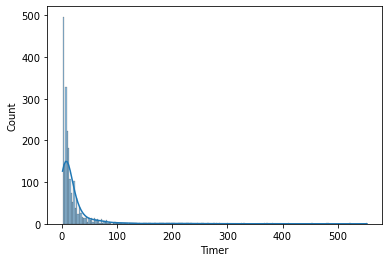

In [397]:
#timer distribution in the dataset
ax = sns.histplot(newDf['Timer'], kde=True)
ax.set( ylabel='Count')

In [398]:
#outlier detection and elimination using IQR

percentile25 = newDf['Timer'].quantile(0.25)
percentile75 = newDf['Timer'].quantile(0.75)
iqr = percentile75 - percentile25

#select upper limit and showcase potential outliers
upperLimit = percentile75 + 1.5*iqr
lowerLimit = 1
newDfOut = newDf[newDf['Timer'] < upperLimit]
newDfOut.drop(newDfOut[newDfOut['Timer'] == 1].index, inplace = True)

C:\Users\ronan\anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [399]:
newDfOut['CarDuration'].value_counts()

0     744
1     263
2     196
3     109
4      89
5      50
7      28
6      23
8      19
12     12
10     11
9      11
18      8
11      5
15      4
16      4
14      3
13      3
19      3
17      2
26      2
28      1
20      1
21      1
25      1
29      1
Name: CarDuration, dtype: int64

[Text(0, 0.5, 'Count')]

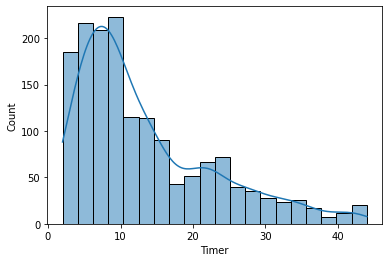

In [400]:
#new timer distribution in the dataset
ax = sns.histplot(newDfOut['Timer'], kde=True)
ax.set( ylabel='Count')

In [401]:
#encoding the values
le = LabelEncoder()
newDfOut['Light'] = le.fit_transform(newDfOut['Light'])
newDfOut['Car'] = le.fit_transform(newDfOut['Car'])
newDfOut['Condition'] = le.fit_transform(newDfOut['Condition'])

<ipython-input-401-f04ce69576d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newDfOut['Light'] = le.fit_transform(newDfOut['Light'])
<ipython-input-401-f04ce69576d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newDfOut['Car'] = le.fit_transform(newDfOut['Car'])
<ipython-input-401-f04ce69576d1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [402]:
#splitting the dataset into features and target
feature_cols = list(newDfOut.columns[:-1])
target_col = newDfOut.columns[-1]

X_all = newDfOut[feature_cols]
Y_all = newDfOut[target_col]

#split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.33, random_state=43)

In [403]:
target_col

'Light'

In [404]:
#gridsearching
param_grid = [{'C': 10**np.linspace(-3,3,20)}]
lin_reg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
logreg = GridSearchCV(lin_reg, param_grid, cv=10, scoring='accuracy', 
                             refit=True)
#training a logistic regression model
logreg.fit(X_train,y_train)

#predicting
y_pred=logreg.best_estimator_.predict(X_test)

In [405]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred, zero_division=1))
print('Precision:',metrics.precision_score(y_test, y_pred, zero_division=1))
print('F1:',metrics.f1_score(y_test, y_pred, zero_division=1))
print('CL Report:',metrics.classification_report(y_test, y_pred, zero_division=1))

Accuracy:  0.7969639468690702
Recall:  0.6504424778761062
Precision: 0.84
F1: 0.7331670822942644
CL Report:               precision    recall  f1-score   support

           0       0.78      0.91      0.84       301
           1       0.84      0.65      0.73       226

    accuracy                           0.80       527
   macro avg       0.81      0.78      0.78       527
weighted avg       0.80      0.80      0.79       527



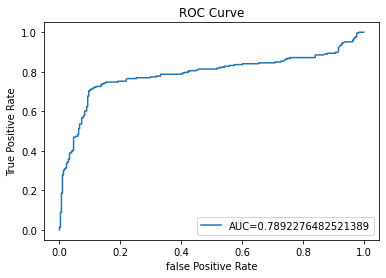

In [406]:
#ROC curve calculation

y_pred_proba= logreg.best_estimator_.predict_proba(X_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [407]:
#training a decision tree classifier
my_random_seed = 45

tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

model = GridSearchCV(DecisionTreeClassifier(my_random_seed), tree_para, cv=5)

model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]})

In [408]:
#decision tree prediction
y_predict = model.best_estimator_.predict(X_test)

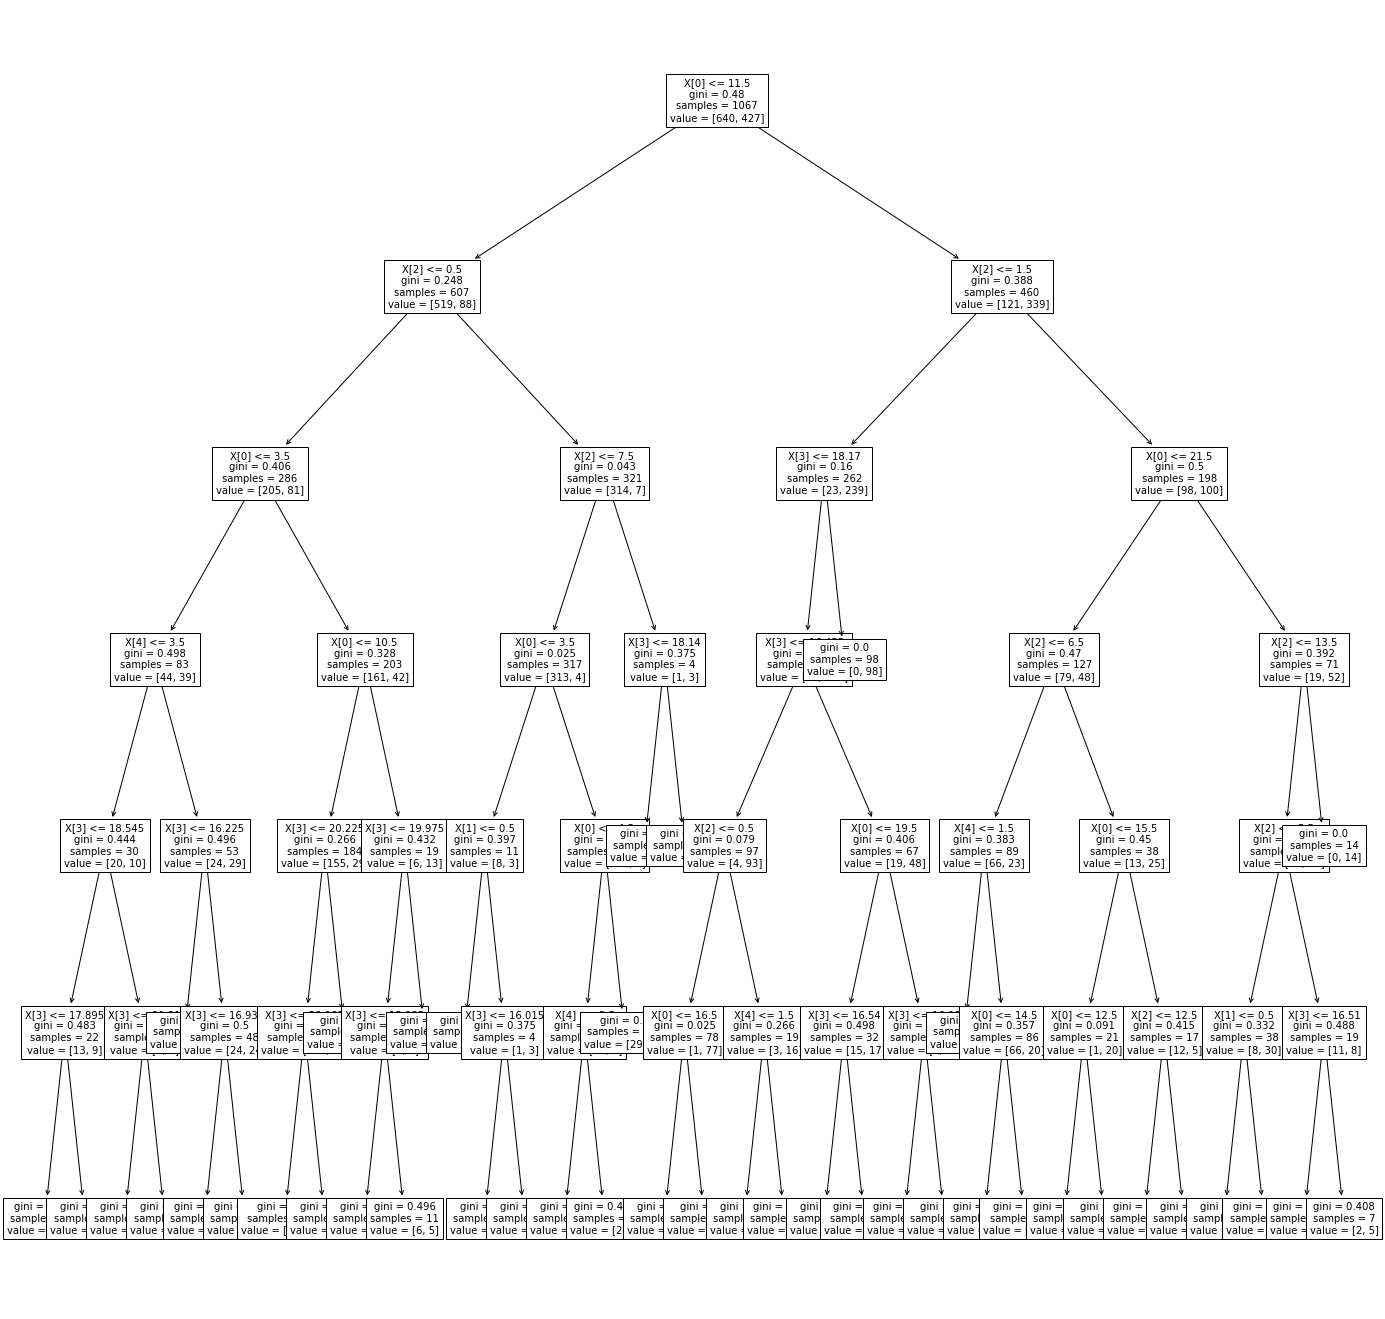

In [409]:
#visualizing the tree
plt.figure(figsize=(24,24))  # set plot size (denoted in inches)
tree.plot_tree(model.best_estimator_, fontsize=10)
plt.show()

In [410]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test, y_predict))
print('Recall: ',metrics.recall_score(y_test, y_predict, zero_division=1))
print('Precision:',metrics.precision_score(y_test, y_predict, zero_division=1))
print('F1:',metrics.f1_score(y_test, y_predict, zero_division=1))
print('CL Report:',metrics.classification_report(y_test, y_predict, zero_division=1))

Accuracy:  0.8444022770398482
Recall:  0.7522123893805309
Precision: 0.8673469387755102
F1: 0.8056872037914692
CL Report:               precision    recall  f1-score   support

           0       0.83      0.91      0.87       301
           1       0.87      0.75      0.81       226

    accuracy                           0.84       527
   macro avg       0.85      0.83      0.84       527
weighted avg       0.85      0.84      0.84       527



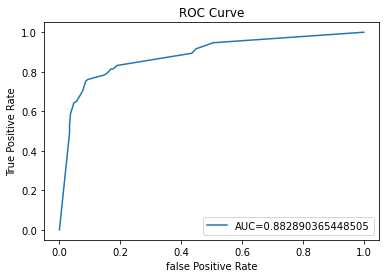

In [411]:
#ROC curve calculation

y_pred_proba= model.best_estimator_.predict_proba(X_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [464]:
#Start of feature testing (Car + CarDuration)

#splitting the dataset into features and target but removing a specific targeted feature.
target_col_feature1 = newDfOut.columns[-1]

X_all_feature1 = newDfOut[['Timer', 'Temperature', 'Condition']]
Y_all_feature1 = newDfOut[target_col_feature1]

#split into training and testing sets
X_train_feature1, X_test_feature1, y_train_feature1, y_test_feature1 = train_test_split(X_all_feature1, Y_all_feature1, test_size=0.33, random_state=43)


#training a decision tree classifier
my_random_seed = 45

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

model = GridSearchCV(RandomForestClassifier(random_state=45), param_grid, cv=5)

model.fit(X_train_feature1, y_train_feature1)
#decision tree prediction
y_predict_feature1 = model.best_estimator_.predict(X_test_feature1)

In [465]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test_feature1, y_predict_feature1))
print('Recall: ',metrics.recall_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('Precision:',metrics.precision_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('F1:',metrics.f1_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('CL Report:',metrics.classification_report(y_test_feature1, y_predict_feature1, zero_division=1))

Accuracy:  0.8159392789373814
Recall:  0.8230088495575221
Precision: 0.7654320987654321
F1: 0.7931769722814499
CL Report:               precision    recall  f1-score   support

           0       0.86      0.81      0.83       301
           1       0.77      0.82      0.79       226

    accuracy                           0.82       527
   macro avg       0.81      0.82      0.81       527
weighted avg       0.82      0.82      0.82       527



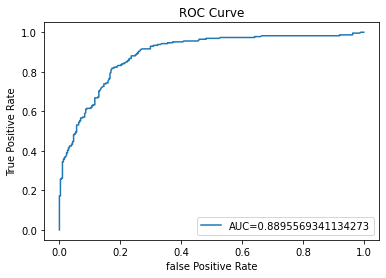

In [466]:
#ROC curve calculation

y_pred_proba_feature1= model.best_estimator_.predict_proba(X_test_feature1) [::,1]

false_positive_rate_feature1, true_positive_rate_feature1, _ = metrics.roc_curve(y_test_feature1, y_pred_proba_feature1)

auc= metrics.roc_auc_score(y_test_feature1, y_pred_proba_feature1)

plt.plot(false_positive_rate_feature1, true_positive_rate_feature1,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [467]:
#Start of feature testing (Condition + Temperature)

#splitting the dataset into features and target but removing a specific targeted feature.
target_col_feature1 = newDfOut.columns[-1]

X_all_feature1 = newDfOut[['Timer', 'Car', 'CarDuration']]
Y_all_feature1 = newDfOut[target_col_feature1]

#split into training and testing sets
X_train_feature1, X_test_feature1, y_train_feature1, y_test_feature1 = train_test_split(X_all_feature1, Y_all_feature1, test_size=0.33, random_state=43)


#training a decision tree classifier
my_random_seed = 45

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

model = GridSearchCV(RandomForestClassifier(random_state=45), param_grid, cv=5)

model.fit(X_train_feature1, y_train_feature1)
#decision tree prediction
y_predict_feature1 = model.best_estimator_.predict(X_test_feature1)

In [468]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test_feature1, y_predict_feature1))
print('Recall: ',metrics.recall_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('Precision:',metrics.precision_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('F1:',metrics.f1_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('CL Report:',metrics.classification_report(y_test_feature1, y_predict_feature1, zero_division=1))

Accuracy:  0.8387096774193549
Recall:  0.7654867256637168
Precision: 0.8439024390243902
F1: 0.8027842227378191
CL Report:               precision    recall  f1-score   support

           0       0.84      0.89      0.86       301
           1       0.84      0.77      0.80       226

    accuracy                           0.84       527
   macro avg       0.84      0.83      0.83       527
weighted avg       0.84      0.84      0.84       527



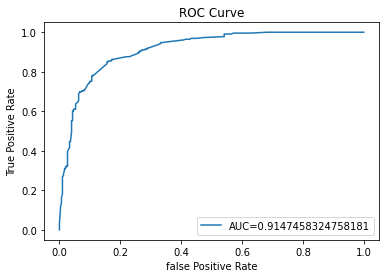

In [469]:
#ROC curve calculation

y_pred_proba_feature1= model.best_estimator_.predict_proba(X_test_feature1) [::,1]

false_positive_rate_feature1, true_positive_rate_feature1, _ = metrics.roc_curve(y_test_feature1, y_pred_proba_feature1)

auc= metrics.roc_auc_score(y_test_feature1, y_pred_proba_feature1)

plt.plot(false_positive_rate_feature1, true_positive_rate_feature1,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [470]:
#Start of feature testing (Timer)

#splitting the dataset into features and target but removing a specific targeted feature.
target_col_feature1 = newDfOut.columns[-1]

X_all_feature1 = newDfOut[['Temperature', 'Condition', 'Car', 'CarDuration']]
Y_all_feature1 = newDfOut[target_col_feature1]

#split into training and testing sets
X_train_feature1, X_test_feature1, y_train_feature1, y_test_feature1 = train_test_split(X_all_feature1, Y_all_feature1, test_size=0.33, random_state=43)


#training a decision tree classifier
my_random_seed = 45

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

model = GridSearchCV(RandomForestClassifier(random_state=45), param_grid, cv=5)

model.fit(X_train_feature1, y_train_feature1)
#decision tree prediction
y_predict_feature1 = model.best_estimator_.predict(X_test_feature1)

In [471]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test_feature1, y_predict_feature1))
print('Recall: ',metrics.recall_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('Precision:',metrics.precision_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('F1:',metrics.f1_score(y_test_feature1, y_predict_feature1, zero_division=1))
print('CL Report:',metrics.classification_report(y_test_feature1, y_predict_feature1, zero_division=1))

Accuracy:  0.6660341555977229
Recall:  0.4911504424778761
Precision: 0.6453488372093024
F1: 0.5577889447236182
CL Report:               precision    recall  f1-score   support

           0       0.68      0.80      0.73       301
           1       0.65      0.49      0.56       226

    accuracy                           0.67       527
   macro avg       0.66      0.64      0.64       527
weighted avg       0.66      0.67      0.66       527



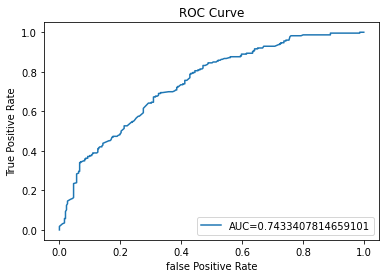

In [472]:
#ROC curve calculation

y_pred_proba_feature1= model.best_estimator_.predict_proba(X_test_feature1) [::,1]

false_positive_rate_feature1, true_positive_rate_feature1, _ = metrics.roc_curve(y_test_feature1, y_pred_proba_feature1)

auc= metrics.roc_auc_score(y_test_feature1, y_pred_proba_feature1)

plt.plot(false_positive_rate_feature1, true_positive_rate_feature1,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

Accuracy:  0.8538899430740038
Recall:  0.7831858407079646
Precision: 0.8634146341463415
F1: 0.8213457076566126
CL Report:               precision    recall  f1-score   support

           0       0.85      0.91      0.88       301
           1       0.86      0.78      0.82       226

    accuracy                           0.85       527
   macro avg       0.86      0.85      0.85       527
weighted avg       0.85      0.85      0.85       527



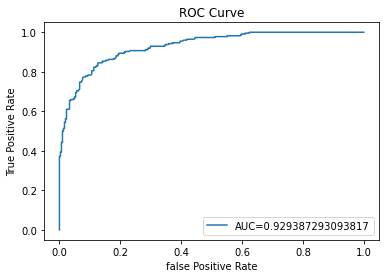

In [463]:
#training a random forest
my_random_seed = 45

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

model = GridSearchCV(RandomForestClassifier(random_state=45), param_grid, cv=5)

model.fit(X_train, y_train)

#prediction
y_predict = model.best_estimator_.predict(X_test)

#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test, y_predict))
print('Recall: ',metrics.recall_score(y_test, y_predict, zero_division=1))
print('Precision:',metrics.precision_score(y_test, y_predict, zero_division=1))
print('F1:',metrics.f1_score(y_test, y_predict, zero_division=1))
print('CL Report:',metrics.classification_report(y_test, y_predict, zero_division=1))

#ROC curve calculation

y_pred_proba= model.best_estimator_.predict_proba(X_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)